In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

from train_utils import plot_confusion_matrix, make_dataframe
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print("Tensorflow version is ", tf.__version__)

Tensorflow version is  1.13.1


Using TensorFlow backend.


## setup training

In [2]:
width_image = 224
height_image = 224
batch_size = 32
img_shape = (width_image, height_image, 3)

categories = os.listdir('dataset\\v3')
data_frames = make_dataframe('dataset\\v3', validation_percentage = 0.13, test_percentage=0.17)

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    vertical_flip=True,
    ##zca_whitening=True,
    rotation_range=15.
)
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

Total size:  501
Training set size:  351
Validation set size:  66
Test set size:  84
Total size:  410
Training set size:  288
Validation set size:  54
Test set size:  68
Total size:  997
Training set size:  699
Validation set size:  130
Test set size:  168
Total size:  527
Training set size:  370
Validation set size:  69
Test set size:  88


In [3]:
# make generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_frames[0],
    x_col='path',
    y_col='label',
    class_mode = 'categorical',
    target_size = (width_image, height_image),
    batch_size = batch_size)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=data_frames[1],
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    target_size=(width_image, height_image),
    batch_size = batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_frames[2],
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    target_size=(width_image, height_image),
    batch_size = batch_size,
    shuffle=False
)

Found 1708 validated image filenames belonging to 4 classes.
Found 319 validated image filenames belonging to 4 classes.
Found 408 validated image filenames belonging to 4 classes.


In [4]:
# get pre-trained MobileNet V2
#base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
#                                                include_top=False,
#                                                weights='imagenet')

#base_model = tf.keras.applications.InceptionResNetV2(input_shape=img_shape,
#                                                include_top=False,
#                                                weights='imagenet')

base_model = tf.keras.applications.densenet.DenseNet121(input_shape=img_shape,
                                                include_top=False,
                                                weights='imagenet')

base_model.trainable = False
# feature extraction reuse, T
#for layer in base_model.layers:
#    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


## create model over pre-trained net

In [5]:
# create model over pre-trained graph
model = tf.keras.Sequential([
    base_model,
#    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
#                       activation=tf.nn.relu, input_shape=(len(categories),)),
#    keras.layers.Dropout(0.5),
#    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
#                       activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(len(categories), activation='softmax')
])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
# add the optmizer, loss function and metric for evaluate the training
optimizer = keras.optimizers.Adam()
# optimizer = keras.optimizers.Nadam()
# optimizer = keras.optimizers.Adadelta()
# tensorflow guide use:
#optimizer = tf.keras.optimizers.RMSprop(lr=0.0001)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

## Tranining Phase

In [7]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
test_steps = test_generator.n // batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs, 
    validation_data = validation_generator,
    validation_steps = validation_steps
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
54/54 [==============================] - 34s 639ms/step - loss: 1.1077 - acc: 0.5304 - val_loss: 0.8653 - val_acc: 0.6426
Epoch 2/10
54/54 [==============================] - 22s 411ms/step - loss: 0.6792 - acc: 0.7441 - val_loss: 0.6247 - val_acc: 0.7555
Epoch 3/10
54/54 [==============================] - 26s 476ms/step - loss: 0.5605 - acc: 0.7922 - val_loss: 0.6169 - val_acc: 0.7555
Epoch 4/10
54/54 [==============================] - 26s 490ms/step - loss: 0.5026 - acc: 0.8238 - val_loss: 0.4766 - val_acc: 0.8245
Epoch 5/10
54/54 [==============================] - 28s 524ms/step - loss: 0.4328 - acc: 0.8525 - val_loss: 0.4249 - val_acc: 0.8370
Epoch 6/10
54/54 [==============================] - 28s 526ms/step - loss: 0.4236 - acc: 0.8407 - val_loss: 0.3987 - val_acc: 0.8652
Epoch 7/10
54/54 [==============================] - 28s 526ms/step - loss: 0.3993 - acc: 0.8677 - val_loss: 0.3832 - val_acc: 0.8652
Epoch 8/10
54/54 [===

## Fine tuning

In [8]:
#Enable chage of all net weight's including the pre-trained
epochs_fine = 200
print("Number of layers in the base model: ", len(base_model.layers))
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

Number of layers in the base model:  427
0 input_1
1 zero_padding2d
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_1
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_b

In [8]:
# set the level to fine-tune
fine_tune_at = 313#141

base_model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

In [9]:
# recompile model with optimizer
optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
#optimizer = tf.keras.optimizers.RMSprop(lr=2e-5)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 2,164,228
Non-trainable params: 4,877,376
_________________________________________________________________


In [10]:
# fit fine-tuning
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs = epochs_fine,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

NameError: name 'epochs_fine' is not defined

## Plotting Validation accuracy/loss

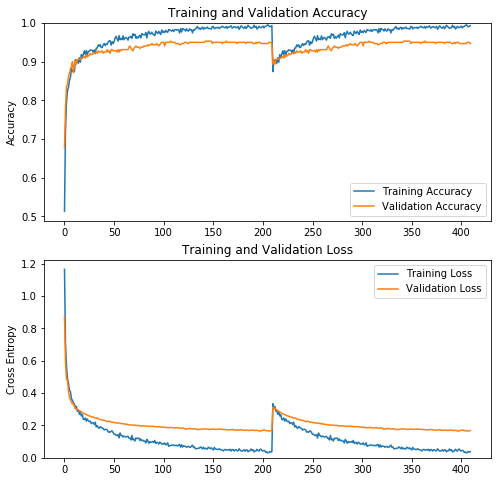

In [14]:
%matplotlib inline

# training and validation accuracy/loss
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

if('history_fine' in globals()):
    acc += history_fine.history['acc']
    val_acc += history_fine.history['val_acc']
    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Plotting confusion matrix

Confusion Matrix
[[ 71   8   0   5]
 [  0  64   1   3]
 [  0   0 168   0]
 [  4   4   3  77]]
Classification Report
              precision    recall  f1-score   support

       glass       0.95      0.85      0.89        84
       metal       0.84      0.94      0.89        68
       paper       0.98      1.00      0.99       168
     plastic       0.91      0.88      0.89        88

    accuracy                           0.93       408
   macro avg       0.92      0.92      0.92       408
weighted avg       0.93      0.93      0.93       408

408/408 [==============================] - 3s 8ms/sample - loss: 0.2354 - acc: 0.9314
Accuracy: 93.1%
Loss: 23.5%


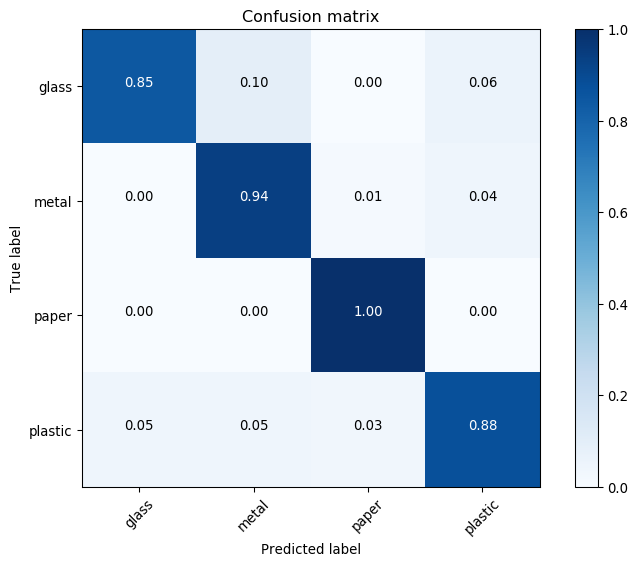

In [15]:
# confusion matrix
Y_pred = model.predict_generator(test_generator, test_steps)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

# classification report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=categories))

# evaluate keras model with model.evaluate()
x, y = zip(*(test_generator[i] for i in range(len(test_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: {0:0.1f}%".format(acc * 100))
print("Loss: {0:0.1f}%".format(loss * 100))


plot_confusion_matrix(test_generator.classes, y_pred, categories)

In [14]:
# save the model
name = '.\\saved_model\\best_densenet121_ft_v3_2019_07_30.h5'
model.save(name)

##### Try to predict with model

In [4]:
from tensorflow.keras.models import Model
categories = os.listdir('dataset\\v3')
loaded_model = keras.models.load_model('.\\saved_model\\best_densenet121_ft_v3_2019_07_30.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


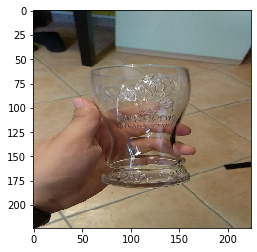

In [22]:
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input

img_path = 'glass.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
#x = x/255
x = preprocess_input(x)
plt.imshow(img)

In [23]:
preds = model.predict_proba(x)
category = model.predict_classes(x)
print(preds)
print(categories[category.argmax()])

[[2.6135423e-04 1.5867392e-03 4.1285810e-01 5.8529383e-01]]
glass
